# Import Libraries

In [12]:
# Numerical and Data Handling
import numpy as np
import pandas as pd
import os

# Audio Processing and Visualization
import librosa
import librosa.display

# Plotting
import matplotlib.pyplot as plt
from adopt import ADOPT
import seaborn as sns

# Use tqdm for progress bar
from tqdm import tqdm

# Process files in parallel using joblib
from joblib import Parallel, delayed
    

# IPython Utilities for Jupyter Notebook
from IPython.display import Audio, Image

In [14]:

base_path = "/home/ali/Arabic-Speech-Emotion-Recognition/KEDAS/Data"
from utils import load_kedas_dataset
kedas_df = load_kedas_dataset(base_path)


500


Processing actors: 100%|██████████| 500/500 [00:00<00:00, 2437.29it/s]


In [18]:
SAMPLE_RATE = 16_000  # 16kHz is optimal for speech-based emotion recognition

Data = kedas_df.copy() #ksu_emotions_df #Bave_df, EYASE_df

from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp (for test and validation)
train_df, temp_df = train_test_split(Data, 
                                    test_size=0.2, 
                                    random_state=455,
                                    stratify=Data.Emotion)

# Second split: Split temp into test and validation (50% each, resulting in 10% of original data each)
test_df, val_df = train_test_split(temp_df,
                                  test_size=0.5,
                                  random_state=455,
                                  stratify=temp_df.Emotion)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

del Data, temp_df

/tmp/ipykernel_10352/130928384.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _= librosa.load(test_df.loc[i, 'Path'], offset=0.5, sr=SAMPLE_RATE)
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/130928384.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _= librosa.load(test_df.loc[i, 'Path'], offset=0.5, sr=SAMPLE_RATE)
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/130928384.py:7: UserWarning: PySoundFile failed. Tr

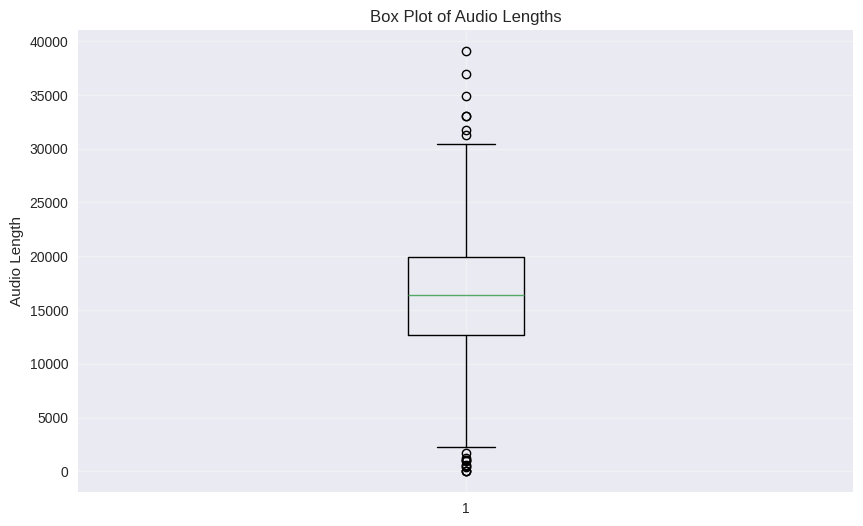

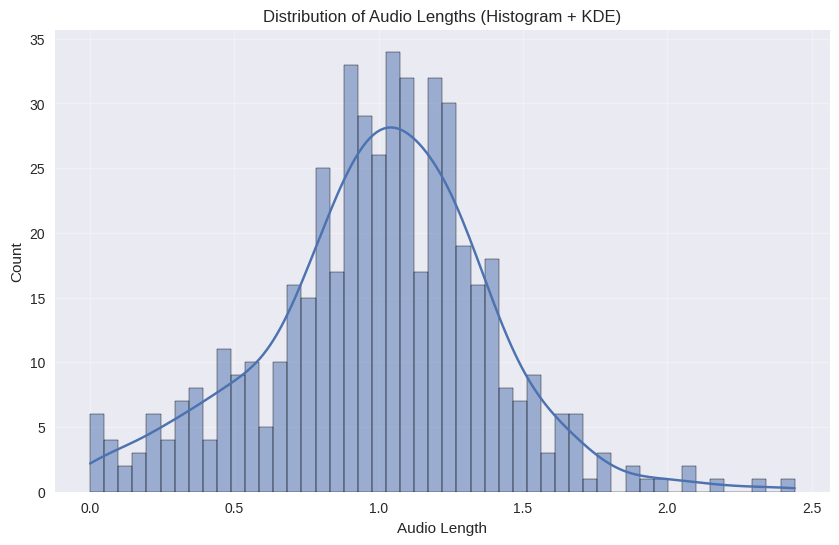

Basic Statistics:
Mean: 1.00
Median: 1.03
Std Dev: 0.39
Min: 0.00
Max: 2.44


In [19]:
# Added By Mohamed To get the whole length of all signals No Need to run again 
import seaborn as sns
length_data = len(test_df)
audio_length =np.zeros(length_data)

for i in range (0,length_data):
    audio, _= librosa.load(test_df.loc[i, 'Path'], offset=0.5, sr=SAMPLE_RATE)
    audio_length[i] = audio.size

# Added By Mohamed To get Familiar with the distribution of all signals No Need to run again

# Box Plot
plt.figure(figsize=(10, 6))
plt.boxplot(audio_length)
plt.title('Box Plot of Audio Lengths')
plt.ylabel('Audio Length')
plt.grid(True, alpha=0.3)
plt.show()

# Histogram + KDE combined using seaborn
durations = audio_length/SAMPLE_RATE
plt.figure(figsize=(10, 6))
sns.histplot(data=durations, kde=True, bins=50)
plt.title('Distribution of Audio Lengths (Histogram + KDE)')
plt.xlabel('Audio Length')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Basic statistics
print("Basic Statistics:")
print(f"Mean: {np.mean(durations):.2f}")
print(f"Median: {np.median(durations):.2f}")
print(f"Std Dev: {np.std(durations):.2f}")
print(f"Min: {np.min(durations):.2f}")
print(f"Max: {np.max(durations):.2f}")


In [20]:
def get_log_mel_spectrogram(
    audio,
    sample_rate,
    n_fft=2048,
    hop_length=256,
    n_mels=128,
    fmin=80,
    fmax=7600,
    window='hann'
):
    """
    Compute the Log-Mel spectrogram of an audio signal.

    Parameters:
    - audio (np.ndarray): Audio time series.
    - sample_rate (int): Sampling rate of the audio signal.
    - n_fft (int): Length of the FFT window.
    - hop_length (int): Number of samples between successive frames.
    - n_mels (int): Number of Mel bands to generate.
    - fmin (float): Lowest frequency (in Hz).
    - fmax (float): Highest frequency (in Hz).
    - window (str): Window function to apply (e.g., 'hann', 'hamming').

    Returns:
    - mel_spec_db (np.ndarray): Log-Mel spectrogram (in dB).
    """
    # Compute Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=n_fft,
        window=window,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
        power=2.0  # Power spectrogram (default)
    )

    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mel_spec_db

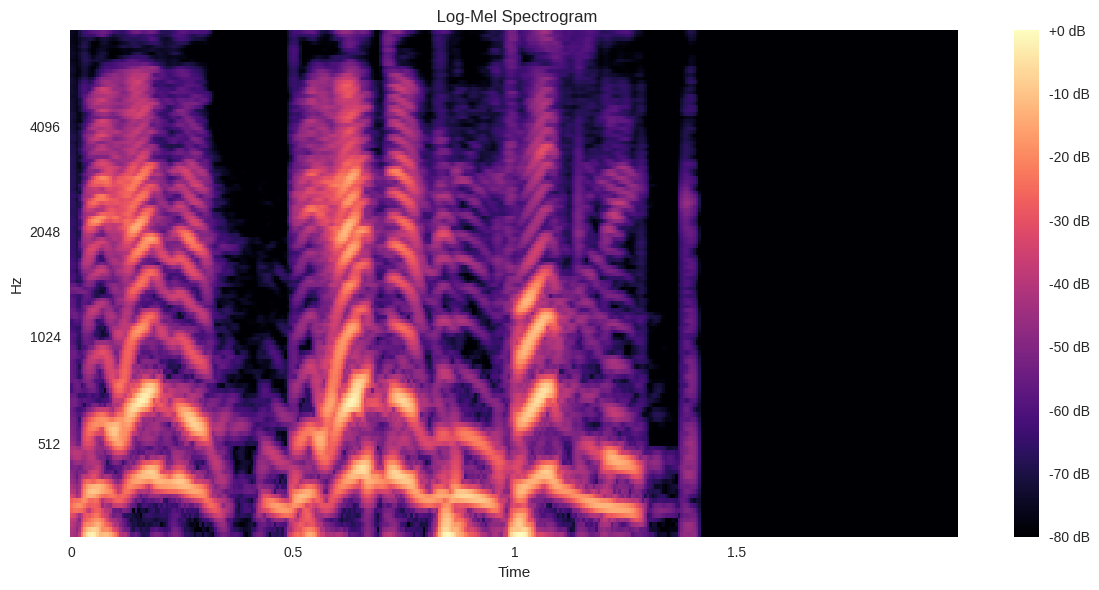

In [21]:
duration = 2
SAMPLE_RATE = 44100
audio, sample_rate = librosa.load(kedas_df.loc[4000, 'Path'], duration=duration, offset=0.5, sr=SAMPLE_RATE)


# Zero-padding the signal for a consistent 3-second input
signal = np.zeros(int(SAMPLE_RATE * duration))
signal[:len(audio)] = audio

# Compute the optimized Log-Mel spectrogram

mel_spectrogram = get_log_mel_spectrogram(signal, SAMPLE_RATE)
#mel_spectrogram = mel_spectrograms[7800]
# Visualize the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(
    mel_spectrogram,
    sr=SAMPLE_RATE,
    hop_length=256,
    y_axis='mel',
    x_axis='time',
    fmin=80,
    fmax=7600
)
plt.colorbar(format='%+2.0f dB')
plt.title(' Log-Mel Spectrogram')
plt.tight_layout()


In [22]:
def sigToSpectogram(data, final_shape, duration = 5 ,sample_rate=22500):
    """
    Perform sigToSpectogram on audio files and compute mel spectrograms.
    
    Args:
        data: DataFrame containing audio file paths
        num_augmentations: Number of augmentations per sample
        sample_rate: Audio sample rate
    
    Returns:
        tuple: (mel_spectrograms, signals)
        - mel_spectrograms: numpy array of mel spectrograms
        - signals: list of audio signals
    """
    
 
    
    # Preallocate arrays
    mel_spectrograms = np.empty(final_shape, dtype=np.float32)
    signals = []
    
    def process_file(file_path):
        try:
            # Load audio file
            audio, _ = librosa.load(
                file_path, 
                duration=duration, 
                offset=0.5, 
                sr=sample_rate,
                res_type='kaiser_fast'  # Faster resampling
            )
            
            # Zero-pad signal
            signal = np.zeros(int(sample_rate * duration), dtype=np.float32)
            signal[:len(audio)] = audio
            
            # Compute mel spectrogram
            mel_spec = get_log_mel_spectrogram(signal, sample_rate=sample_rate)
            
            return mel_spec, signal
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return None, None

    # Process files in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(file_path) 
        for file_path in tqdm(data.Path, desc="Processing audio files")
    )
    
    # Store results in mel_spectrograms array and signals list
    for i, (mel_spec, signal) in enumerate(results):
        if mel_spec is not None:
            mel_spectrograms[i] = mel_spec
            signals.append(signal)
    
    # Convert signals list to numpy array for consistency
    signals = np.array(signals, dtype=np.float32)
    
    return mel_spectrograms, signals

#mel_spectrograms = []
num_augmentations = 2
final_shape = (train_df.shape[0], mel_spectrogram.shape[0], mel_spectrogram.shape[1])

mel_spectrograms, signals = sigToSpectogram(data=train_df,final_shape=final_shape,duration=duration,sample_rate=SAMPLE_RATE)

test_shape = (test_df.shape[0], mel_spectrogram.shape[0], mel_spectrogram.shape[1])
mel_spectrograms_test, _ = sigToSpectogram(data=test_df,final_shape=test_shape,duration=duration,sample_rate=SAMPLE_RATE)

val_shape = (val_df.shape[0], mel_spectrogram.shape[0], mel_spectrogram.shape[1])
mel_spectrograms_val, _ = sigToSpectogram(data=val_df,final_shape=val_shape,duration=duration,sample_rate=SAMPLE_RATE)

Processing audio files:   0%|          | 0/4000 [00:00<?, ?it/s]

/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio._

Processing audio files:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio._

Processing audio files:   0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_10352/1386147016.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [25]:
print("Train Mel-Spectrogram Shape:", mel_spectrograms_val.shape)

Train Mel-Spectrogram Shape: (500, 128, 345)


In [26]:

def addAWGN(signals, num_bits=16, augmented_num=1, snr_low=15, snr_high=30):
    # Assuming signals is a 2D array with shape (num_signals, signal_length)
    num_signals, signal_len = signals.shape
    
    # Generate White Gaussian noise
    # Shape: (num_signals, augmented_num, signal_len)
    noise = np.random.normal(size=(num_signals, augmented_num, signal_len))
    
    # Normalize signals and noise
    norm_constant = 2.0**(num_bits-1)
    signals_norm = signals / norm_constant  # Shape: (num_signals, signal_len)
    noise_norm = noise / norm_constant      # Shape: (num_signals, augmented_num, signal_len)
    
    # Compute signal and noise power
    s_power = np.sum(signals_norm ** 2, axis=1) / signal_len  # Shape: (num_signals,)
    n_power = np.sum(noise_norm ** 2, axis=2) / signal_len    # Shape: (num_signals, augmented_num)
    
    # Random SNR: Uniform [15, 30] in dB
    target_snr = np.random.randint(snr_low, snr_high, size=(num_signals, augmented_num))
    
    # Compute K (covariance matrix) for each noise
    # Shape: (num_signals, augmented_num)
    K = np.sqrt((s_power[:, np.newaxis] / n_power) * 10 ** (- target_snr / 10))
    
    # Expand K to match noise dimensions
    # Shape: (num_signals, augmented_num, signal_len)
    K_expanded = np.expand_dims(K, axis=2) * np.ones((1, 1, signal_len))
    
    # Generate noisy signals
    # Shape: (num_signals, augmented_num, signal_len)
    noisy_signals = signals[:, np.newaxis, :] + K_expanded * noise
    
    return noisy_signals

def batch_addAWGN_with_spectogram(signals, sample_rate=22500, num_bits=16, augmented_num=1, snr_low=15, snr_high=30, batch_size=None):
    num_signals = signals.shape[0]
    signal_len = signals.shape[1]

    if batch_size is None:
        batch_size = num_signals // 4
    
    
    augmented_specs = []
    
    # Process in batches
    for start_idx in range(0, num_signals, batch_size):
        end_idx = min(start_idx + batch_size, num_signals)
        batch = signals[start_idx:end_idx]
        
        # Apply AWGN to the batch
        noisy_batch = addAWGN(batch, 
                             num_bits=num_bits, 
                             augmented_num=1,
                             snr_low=snr_low, 
                             snr_high=snr_high)
        print(noisy_batch.shape)
        
        # Reshape to 2D: (batch_size, signal_length)
        noisy_batch = noisy_batch.reshape(-1, signal_len)
        print(noisy_batch.shape)

        
        # Convert to spectrograms
        specs = np.array([get_log_mel_spectrogram(signal, sample_rate=sample_rate) 
                         for signal in noisy_batch])
        
        augmented_specs.append(specs)
    
    # Combine all batches
    return np.vstack(augmented_specs)

def create_multiple_augmentations_with_specs(signals, mel_spectrograms, labels, num_augmentations, sample_rate=22500, **kwargs):
    # Convert original signals to spectrograms
    original_specs = mel_spectrograms
    all_specs = [original_specs]
    all_labels = [labels]
    
    for _ in range(num_augmentations):
        augmented_specs = batch_addAWGN_with_spectogram(signals, sample_rate=sample_rate, **kwargs)
        all_specs.append(augmented_specs)
        all_labels.append(labels)
    
    # Combine all augmentations and labels
    augmented_specs = np.vstack(all_specs)
    augmented_labels = np.concatenate(all_labels)
    
    return augmented_specs, augmented_labels

# With saving to disk:
def create_multiple_augmentations_with_specs_save(signals, mel_spectrograms, labels, num_augmentations, save_path, sample_rate=22500, **kwargs):
    # Convert and save original spectrograms and labels
    original_specs = mel_spectrograms
    np.save(f"{save_path}/original_specs.npy", original_specs)
    np.save(f"{save_path}/original_labels.npy", labels)
    
    for i in range(num_augmentations):
        augmented_specs = batch_addAWGN_with_spectogram(signals, sample_rate=sample_rate, **kwargs)
        # Save each augmentation and its labels
        np.save(f"{save_path}/augmentation_specs_{i}.npy", augmented_specs)
        np.save(f"{save_path}/augmentation_labels_{i}.npy", labels)




labels = np.array(train_df.Emotion)
batch_size = signals.shape[0] // 2
num_augmentations = 2

augmented_specs, augmented_labels = create_multiple_augmentations_with_specs(
    signals,
    mel_spectrograms,
    labels,
    num_augmentations=num_augmentations,
    batch_size=batch_size,
    snr_low=15,
    snr_high=30
)

del mel_spectrograms, signals, train_df



(2000, 1, 88200)
(2000, 88200)
(2000, 1, 88200)
(2000, 88200)
(2000, 1, 88200)
(2000, 88200)
(2000, 1, 88200)
(2000, 88200)


# Models


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the loss function once
loss_fn = nn.CrossEntropyLoss()

def make_train_step(model, optimizer):
    def train_step(X, Y):
        # Set model to train mode
        model.train()

        # Move data to the same device as model
        X = X.to(next(model.parameters()).device)
        Y = Y.to(next(model.parameters()).device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output_logits = model(X)

        # Compute loss
        loss = loss_fn(output_logits, Y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute predictions and accuracy
        with torch.no_grad():
            predictions = torch.argmax(output_logits, dim=1)
            correct = (predictions == Y).sum().item()
            accuracy = correct / Y.size(0) * 100.0

        return loss.item(), accuracy
    return train_step

def make_validate_fnc(model):
    def validate(X, Y):
        model.eval()
        with torch.no_grad():
            # Move data to the same device as model
            X = X.to(next(model.parameters()).device)
            Y = Y.to(next(model.parameters()).device)

            output_logits = model(X)
            loss = loss_fn(output_logits, Y)
            predictions = torch.argmax(output_logits, dim=1)
            correct = (predictions == Y).sum().item()
            accuracy = correct / Y.size(0) * 100.0
        return loss.item(), accuracy, predictions
    return validate

from model import EmotionRecognitionModel


Ali's shenanigans 

In [35]:
X_train = np.expand_dims(augmented_specs,1)
Y_train = augmented_labels



del augmented_specs

X_test = np.expand_dims(mel_spectrograms_test, 1)
Y_test = np.array(test_df.Emotion)
X_val = np.expand_dims(mel_spectrograms_val, 1)
Y_val = np.array(val_df.Emotion)

del mel_spectrograms_test,   mel_spectrograms_val, augmented_labels




NameError: name 'mel_spectrograms_test' is not defined

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

b,c,h,w = X_train.shape
X_train = np.reshape(X_train, newshape=(b,-1))
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, newshape=(b,c,h,w))

b,c,h,w = X_test.shape
X_test = np.reshape(X_test, newshape=(b,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, newshape=(b,c,h,w))

b,c,h,w = X_val.shape
X_val = np.reshape(X_val, newshape=(b,-1))
X_val = scaler.transform(X_val)
X_val = np.reshape(X_val, newshape=(b,c,h,w))


In [39]:
np.unique(Y_train, return_counts=True), np.unique(Y_test, return_counts=True), np.unique(Y_val, return_counts=True)


((array([0, 1, 2, 3, 4]), array([2400, 2400, 2400, 2400, 2400])),
 (array([0, 1, 2, 3, 4]), array([100, 100, 100, 100, 100])),
 (array([0, 1, 2, 3, 4]), array([100, 100, 100, 100, 100])))

MODIFIED CODE

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device is {device}')

# Hyperparameters
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
EARLY_STOPPING_PATIENCE = 20


# Initialize model
num_emotions = np.unique(Y_train).shape[0]
model = EmotionRecognitionModel(num_emotions,input_height=128, kernel_size=10, padding=4).to(device)
#model = ImprovedEmotionRecognitionModel(num_emotions,input_height=128).to(device)
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters()))

# Optimizer and loss function
optimizer = ADOPT(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Prepare datasets and data loaders
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(Y_train).long())
val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(Y_val).long())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Training and validation functions
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    epoch_loss = 0
    correct_preds = 0
    total_samples = 0

    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, Y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        epoch_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == Y_batch).sum().item()
        total_samples += Y_batch.size(0)

    epoch_loss /= total_samples
    accuracy = (correct_preds / total_samples) * 100
    return epoch_loss, accuracy

def validate_epoch(model, loader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            outputs = model(X_batch)
            loss = loss_fn(outputs, Y_batch)

            # Accumulate metrics
            epoch_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == Y_batch).sum().item()
            total_samples += Y_batch.size(0)

    epoch_loss /= total_samples
    accuracy = (correct_preds / total_samples) * 100
    return epoch_loss, accuracy

# Early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    print(f'Epoch {epoch}/{EPOCHS}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered!")
            break

print("Training complete.")


Selected device is cuda
Number of trainable parameters: 1473190


/home/ali/anaconda3/envs/robodiff/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100: Train Loss: 1.5051, Train Acc: 29.28%, Val Loss: 1.4397, Val Acc: 31.20%
Epoch 2/100: Train Loss: 1.0127, Train Acc: 59.06%, Val Loss: 0.5387, Val Acc: 82.40%
Epoch 3/100: Train Loss: 0.3314, Train Acc: 89.62%, Val Loss: 0.1878, Val Acc: 93.60%
Epoch 4/100: Train Loss: 0.1742, Train Acc: 94.90%, Val Loss: 0.1517, Val Acc: 94.80%
Epoch 5/100: Train Loss: 0.1358, Train Acc: 96.00%, Val Loss: 0.1370, Val Acc: 96.00%
Epoch 6/100: Train Loss: 0.1141, Train Acc: 96.53%, Val Loss: 0.1028, Val Acc: 96.60%
Epoch 7/100: Train Loss: 0.0875, Train Acc: 97.51%, Val Loss: 0.0932, Val Acc: 96.60%
Epoch 8/100: Train Loss: 0.0703, Train Acc: 98.12%, Val Loss: 0.1192, Val Acc: 97.00%
Epoch 9/100: Train Loss: 0.0636, Train Acc: 98.42%, Val Loss: 0.0843, Val Acc: 97.60%
Epoch 10/100: Train Loss: 0.0558, Train Acc: 98.50%, Val Loss: 0.1058, Val Acc: 96.40%
Epoch 11/100: Train Loss: 0.0528, Train Acc: 98.59%, Val Loss: 0.0694, Val Acc: 98.00%
Epoch 12/100: Train Loss: 0.0482, Train Acc: 98.78%,

KeyboardInterrupt: 

Retraining if needed


In [19]:
EPOCHS = 70
BATCH_SIZE = 256
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-6
EARLY_STOPPING_PATIENCE = 15
# Early stopping variables
best_val_loss = float('inf')
epochs_no_improve = 0


# Load the saved model and optimizer state
checkpoint_path = 'best_model.pth'  # Path to the saved model checkpoint
try:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Model weights loaded successfully from {checkpoint_path}.")
except FileNotFoundError:
    print(f"No checkpoint found at {checkpoint_path}. Starting from scratch.")

# If you also saved optimizer state and scheduler:
# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
optimizer = ADOPT(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Continue training loop
for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    print(f'Epoch {epoch}/{EPOCHS}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Save the best model again during resumed training
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered!")
            break

print("Continued Training complete.")


Model weights loaded successfully from best_model.pth.


/tmp/ipykernel_16602/3995736149.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Epoch 1/70: Train Loss: 0.1576, Train Acc: 94.38%, Val Loss: 0.4676, Val Acc: 84.68%
Epoch 2/70: Train Loss: 0.1108, Train Acc: 96.33%, Val Loss: 0.4475, Val Acc: 86.49%
Epoch 3/70: Train Loss: 0.1049, Train Acc: 96.53%, Val Loss: 0.4427, Val Acc: 86.19%
Epoch 4/70: Train Loss: 0.0951, Train Acc: 96.88%, Val Loss: 0.4466, Val Acc: 85.89%
Epoch 5/70: Train Loss: 0.0986, Train Acc: 96.77%, Val Loss: 0.4357, Val Acc: 85.59%
Epoch 6/70: Train Loss: 0.0989, Train Acc: 96.56%, Val Loss: 0.4252, Val Acc: 86.49%
Epoch 7/70: Train Loss: 0.0937, Train Acc: 96.87%, Val Loss: 0.4288, Val Acc: 86.19%
Epoch 8/70: Train Loss: 0.0941, Train Acc: 96.77%, Val Loss: 0.4279, Val Acc: 86.49%
Epoch 9/70: Train Loss: 0.0883, Train Acc: 97.11%, Val Loss: 0.4257, Val Acc: 85.89%
Epoch 10/70: Train Loss: 0.0868, Train Acc: 97.33%, Val Loss: 0.4209, Val Acc: 85.59%
Epoch 11/70: Train Loss: 0.0932, Train Acc: 97.05%, Val Loss: 0.4142, Val Acc: 85.89%
Epoch 12/70: Train Loss: 0.0889, Train Acc: 97.05%, Val Loss: 0

Selected device is cuda


/tmp/ipykernel_10352/2376361188.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test loss: 0.086
Test accuracy: 97.40%


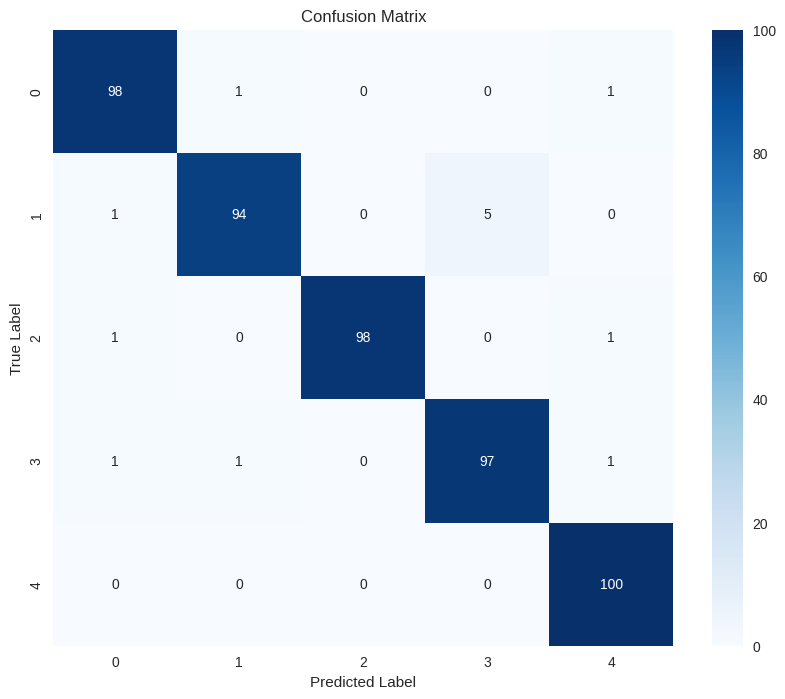


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.94      0.96       100
           2       1.00      0.98      0.99       100
           3       0.95      0.97      0.96       100
           4       0.97      1.00      0.99       100

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500


F1 Scores:
Micro F1: 0.974
Macro F1: 0.974
Weighted F1: 0.974


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Selected device is {device}')



# Load the best model (if you saved it during training)
num_emotions = np.unique(Y_test).shape[0]
input_height = 128  # Height of your spectrograms
model = EmotionRecognitionModel(num_emotions, input_height, kernel_size=10, padding=4).to(device)
model.load_state_dict(torch.load('best_model.pth'))
BATCH_SIZE = 32
# Prepare the test dataset and DataLoader
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(Y_test).long())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define the loss function (assuming it's the same as used during training)
loss_fn = nn.CrossEntropyLoss()

# Test function
def test_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, Y_batch)

            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == Y_batch).sum().item()
            total_samples += Y_batch.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(Y_batch.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = (correct_preds / total_samples) * 100

    return avg_loss, accuracy, all_predictions, all_labels

# Run the test
test_loss, test_acc, predictions, labels = test_model(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.3f}')
print(f'Test accuracy: {test_acc:.2f}%')

# Compute and plot confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report (includes precision, recall, f1-score)
emotion_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Angry', 'Fear'] 
print("\nClassification Report:")
print(classification_report(labels, predictions))

# If you want to calculate F1 scores separately
from sklearn.metrics import f1_score

# Micro F1 score (calculated globally)
micro_f1 = f1_score(labels, predictions, average='micro')
# Macro F1 score (calculated for each label then averaged)
macro_f1 = f1_score(labels, predictions, average='macro')
# Weighted F1 score (calculated for each label and weighted by support)
weighted_f1 = f1_score(labels, predictions, average='weighted')

print("\nF1 Scores:")
print(f"Micro F1: {micro_f1:.3f}")
print(f"Macro F1: {macro_f1:.3f}")
print(f"Weighted F1: {weighted_f1:.3f}")

In [44]:
# Ensure you have the necessary imports
# from your model and training code

# Set device (assuming 'device' is already defined)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'



# Test function
def test_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, Y_batch)

            # Accumulate loss and accuracy
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_preds += (predicted == Y_batch).sum().item()
            total_samples += Y_batch.size(0)

            # Store predictions and labels for further analysis if needed
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(Y_batch.cpu().numpy())

    avg_loss = total_loss / total_samples
    accuracy = (correct_preds / total_samples) * 100

    return avg_loss, accuracy, all_predictions, all_labels

# Run the test
test_loss, test_acc, predictions, labels = test_model(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.3f}')
print(f'Test accuracy: {test_acc:.2f}%')

Test loss: 0.086
Test accuracy: 97.40%


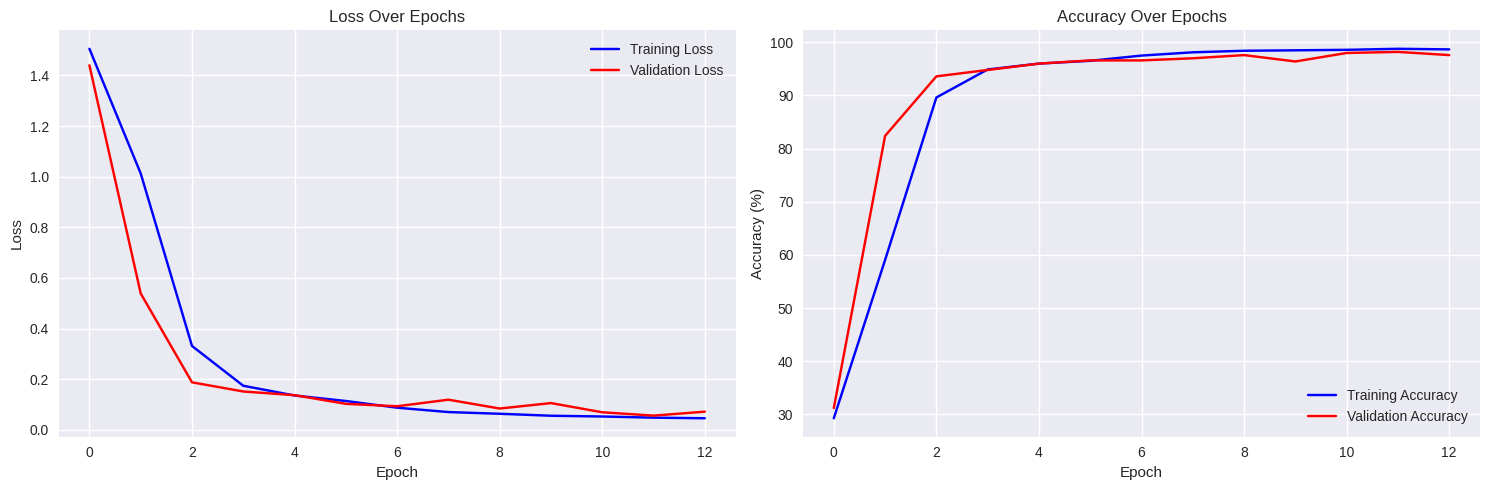

In [45]:
# Create subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot losses
axes[0].plot(train_losses, 'b-', label='Training Loss')
axes[0].plot(val_losses, 'r-', label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True)

# Plot accuracies
axes[1].plot(train_accuracies, 'b-', label='Training Accuracy')
axes[1].plot(val_accuracies, 'r-', label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [2]:
import numpy as np

def save_datasets(X_train, X_val, X_test, Y_train, Y_val, Y_test, filename='dataset'):
    """
    Save training, validation and test sets
    
    Parameters:
    X_train, X_val, X_test: Features for train, validation and test sets
    y_train, y_val, y_test: Labels for train, validation and test sets
    filename: Name of the file to save (without extension)
    """
    np.savez(filename,
             X_train=X_train,
             X_val=X_val,
             X_test=X_test,
             Y_train=Y_train,
             Y_val=Y_val,
             Y_test=Y_test)
    print(f"Datasets saved to {filename}.npz")

def load_datasets(filename='dataset'):
    """
    Load training, validation and test sets
    
    Parameters:
    filename: Name of the file to load (without extension)
    
    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    data = np.load(f"{filename}.npz")
    return (data['X_train'], data['X_val'], data['X_test'],
            data['Y_train'], data['Y_val'], data['Y_test'])


    # Save datasets
#save_datasets(X_train, X_val, X_test, Y_train, Y_val, Y_test, 'my_datasets')

# Load datasets
X_train, X_val, X_test, Y_train, Y_val, Y_test = load_datasets('my_datasets')

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((7830, 1, 128, 626),
 (333, 1, 128, 626),
 (333, 1, 128, 626),
 (7830,),
 (333,),
 (333,))